# SCALE method

This notebook aims at evaluating the **SCALE method**.

**SCALE** method basically consists in re-using existing logit-based OOD methods, but with penultimate layer **activations scaled**. Let $a$ be the activation vector, and $P_p(a)$ the $p$-th percentile of $a$'s values. The scaling is computed using the formula
$$
s = \exp(\frac{\sum_{i} a_i}{\sum_{a_i > P_p(a)} a_i})
$$

Here, we focus on a toy convolutional network trained on MNIST[0-4] challenged on MNIST[5-9].

**Reference**  
_Scaling for Training Time and Post-hoc Out-of-distribution Detection Enhancement_, ICLR 2024
<https://arxiv.org/pdf/2111.12797.pdf>

### Imports


In [2]:
%load_ext autoreload

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from IPython.display import clear_output
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from oodeel.methods import MLS, Energy, GEN, ODIN
from oodeel.eval.metrics import bench_metrics
from oodeel.eval.plots import plot_ood_scores, plot_roc_curve, plot_2D_features
from oodeel.datasets import OODDataset
from oodeel.utils.tf_training_tools import train_tf_model

Note that models are saved at _~/.oodeel/saved_models_ and data is supposed to be found
at _~/.oodeel/datasets_ by default. Change the following cell for a custom path.


In [3]:
model_path = os.path.expanduser("~/") + ".oodeel/saved_models"
data_path = os.path.expanduser("~/") + ".oodeel/datasets"
os.makedirs(model_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)

## MNIST[0-4] vs MNIST[5-9]

We train a toy convolutional network on the MNIST dataset restricted to digits 0 to 4. After fitting the train subset of this dataset to different OOD methods with SCALE option enabled, we will compare the scores returned for MNIST[0-4] (in-distrubtion) and MNIST[5-9] (out-of-distribution) test subsets.

### Data loading

- In-distribution data: MNIST[0-4]
- Out-of-distribution data: MNIST[5-9]

> **Note:** We denote In-Distribution (ID) data with `_in` and Out-Of-Distribution (OOD)
> data with `_out` to avoid confusion with OOD detection which is the name of the task,
> and is therefore used to denote core classes such as `OODDataset` and `OODBaseDetector`.


In [4]:
# === Load ID and OOD data ===
batch_size = 128

# 1a- Load in-distribution dataset: CIFAR-10
ds_fit = OODDataset("cifar10", load_kwargs={"split": "train"}, input_key="image")
ds_in = OODDataset("cifar10", load_kwargs={"split": "test"}, input_key="image")

# 1b- Load out-of-distribution dataset: SVHN
ds_out = OODDataset("svhn_cropped", load_kwargs={"split": "test"})


# 2- prepare data (preprocess, shuffle, batch)
def preprocess_fn(*inputs):
    x = inputs[0] / 255
    return tuple([x] + list(inputs[1:]))


ds_fit = ds_fit.prepare(batch_size, preprocess_fn)
ds_in = ds_in.prepare(batch_size, preprocess_fn)
ds_out = ds_out.prepare(batch_size, preprocess_fn)

clear_output()

### Model training

Now let's train a simple model on MNIST[0-4] using `train_tf_model` function.


79/79 [==============================] - 4s 15ms/step - loss: 0.1268 - accuracy: 0.9278
Test accuracy:	0.9278

=== Penultimate features viz ===


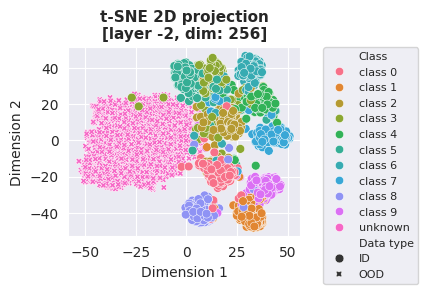

In [5]:
# === Load model ===
# ResNet pretrained on CIFAR-10
model_path_resnet_cifar10 = tf.keras.utils.get_file(
    "cifar10_resnet256.h5",
    origin="https://share.deel.ai/s/kram9kLpx6JwRX4/download/cifar10_resnet256.h5",
    cache_dir=model_path,
    cache_subdir="",
)
model = tf.keras.models.load_model(model_path_resnet_cifar10)

# Evaluate model
model.compile(metrics=["accuracy"])
_, accuracy = model.evaluate(ds_in)
print(f"Test accuracy:\t{accuracy:.4f}")

# penultimate features 2d visualization
print("\n=== Penultimate features viz ===")
plt.figure(figsize=(4.5, 3))
plot_2D_features(
    model=model,
    in_dataset=ds_in,
    out_dataset=ds_out,
    output_layer_id=-2,
)
plt.tight_layout()
plt.show()

### SCALE scores

We now fit some OOD detectors using SCALE + [MLS, MSP, Energy, Entropy, ODIN] with MNIST[0-4] train dataset, and compare OOD scores returned for MNIST[0-4] (ID) and MNIST[5-9] (OOD) test datasets.

=== ODIN ===
~ Without SCALE ~


auroc      0.950461
fpr95tpr   0.151100


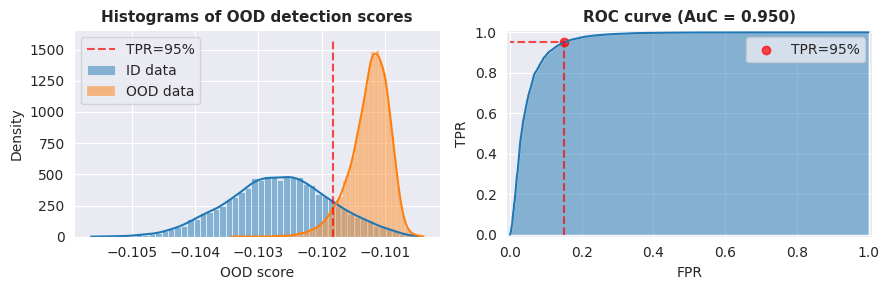

~ With SCALE ~
auroc      0.977004
fpr95tpr   0.088600


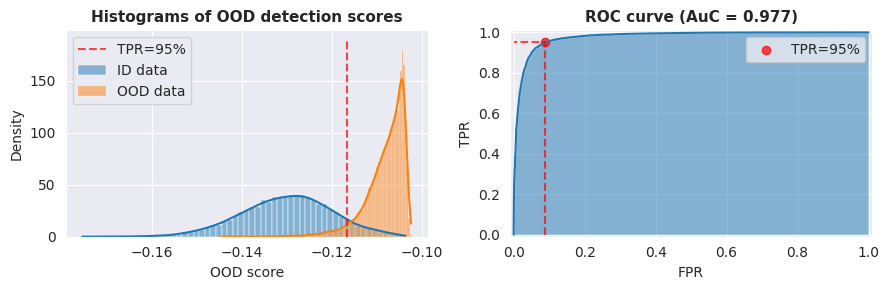

=== MLS ===
~ Without SCALE ~
auroc      0.915862
fpr95tpr   0.205800


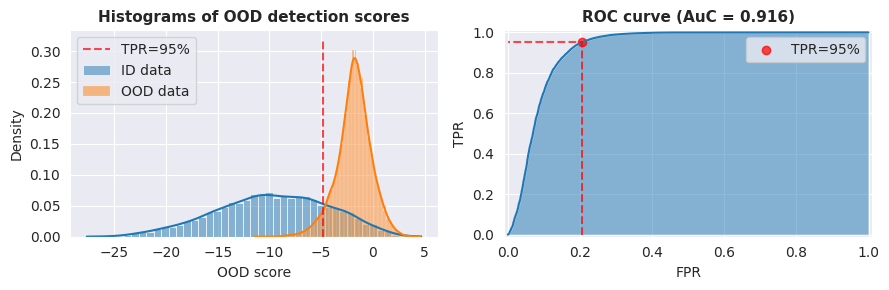

~ With SCALE ~
auroc      0.945726
fpr95tpr   0.132300


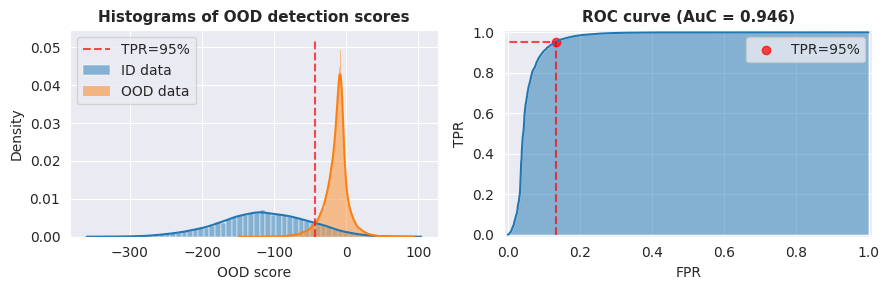

=== ENERGY ===
~ Without SCALE ~
auroc      0.909190
fpr95tpr   0.206900


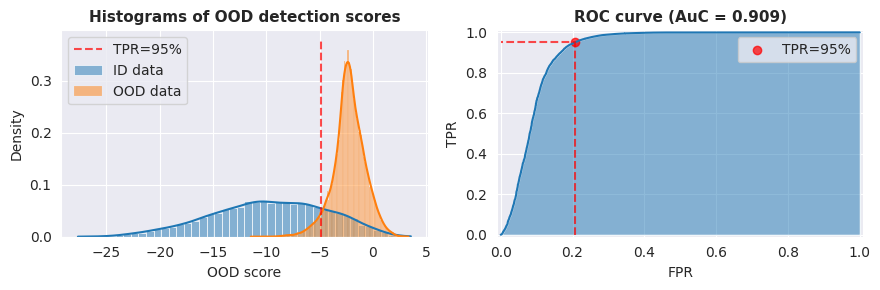

~ With SCALE ~
auroc      0.945676
fpr95tpr   0.132300


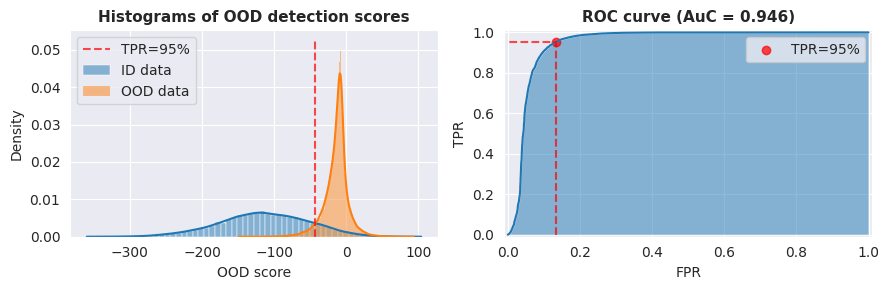

In [6]:
%autoreload 2
detectors = {
    "odin": {
        "class": ODIN,
        "kwargs": dict(temperature=1000),
    },
    "mls": {
        "class": MLS,
        "kwargs": dict(),
    },
    "energy": {
        "class": Energy,
        "kwargs": dict(),
    },
}

for d in detectors.keys():
    print(f"=== {d.upper()} ===")

    for use_scale in [False, True]:
        print(["~ Without", "~ With"][int(use_scale)] + " SCALE ~")
        # === ood scores ===
        d_kwargs = detectors[d]["kwargs"]
        d_kwargs.update(dict(
            use_scale=use_scale,
            scale_percentile=0.85,
        ))
        detector = detectors[d]["class"](**d_kwargs)
        detector.fit(model)
        scores_in, _ = detector.score(ds_in)
        scores_out, _ = detector.score(ds_out)

        # === metrics ===
        # auroc / fpr95
        metrics = bench_metrics(
            (scores_in, scores_out),
            metrics=["auroc", "fpr95tpr"],
        )
        for k, v in metrics.items():
            print(f"{k:<10} {v:.6f}")

        log_scale = d in ["gen"]
        # hists / roc
        plt.figure(figsize=(9, 3))
        plt.subplot(121)
        if d == "msp":
            # Normalize scores for a better hist visualization
            minim = np.min([np.min(scores_in), np.min(scores_out)])
            scores_in_ = scores_in - 2 * minim + np.min(scores_in[np.where(scores_in != minim)])
            scores_out_ = scores_out - 2 * minim + np.min(scores_in[np.where(scores_in != minim)])
            plot_ood_scores(scores_in_, scores_out_, log_scale=log_scale)
        else:
            plot_ood_scores(scores_in, scores_out, log_scale=log_scale)
        plt.subplot(122)
        plot_roc_curve(scores_in, scores_out)
        plt.tight_layout()
        plt.show()